In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import re
import gensim

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/My Drive/twitter sentiment/train.csv')

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
class_weights = list(class_weight.compute_class_weight('balanced',
                                                       np.unique(train.label),
                                                       train.label))

In [7]:
class_weights.sort()

In [8]:
class_weights

[0.5377187079407806, 7.128010704727921]

In [9]:
weights = {}

In [10]:
for index, weight in enumerate(class_weights):
  weights[index]=weight

In [11]:
weights

{0: 0.5377187079407806, 1: 7.128010704727921}

In [12]:
 train['tweet'][0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [13]:
mapper = {0: "Normal", 1: "Hate_speech"}
def Mapper(label):
    return mapper[int(label)]

In [14]:
train.label = train.label.apply(lambda x: Mapper(x))

# Tweet Cleaning

In [15]:
train.label.value_counts()

Normal         29720
Hate_speech     2242
Name: label, dtype: int64

In [16]:
## So the data is highly imbalanced. Cleaning the data to get started

In [17]:
## Function for cleaning the data

def clean_tweet(text):
    # For removing mentions
    text = re.sub(r'@[A-Za-z0-9]+','', text) 
    
    # For removing Hashtags
    text = re.sub(r'#', '', text)
    
    # For removing RT
    text = re.sub(r'RT[\s]+', '', text)
    
    # For removing Hyperlinks
    text = re.sub(r'https?\/\/\S+', '', text)
    
    # Changing everthing to lowercase
    text = text.lower()
    
    return text

In [18]:
train['clean_tweet'] = train['tweet'].apply(clean_tweet)

In [19]:
train.head()

,id,label,tweet,clean_tweet
0,1,Normal,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,Normal,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can't use cause the...
2,3,Normal,bihday your majesty,bihday your majesty
3,4,Normal,#model i love u take with u all the time in ...,model i love u take with u all the time in u...
4,5,Normal,factsguide: society now #motivation,factsguide: society now motivation


### Now the basic cleaning is done

In [20]:
train['clean_tweet'][0]

'  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   run'

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [23]:
stopwords = stopwords.words('english')

In [24]:
stopwords[0]

'i'

In [25]:
example = 'my name is aaron'

In [26]:
example_words = example.split()

In [27]:
result_words = [word for word in example_words if word.lower() not in stopwords]
result = ' '.join(result_words)
        
        
        

In [28]:
print(result)

name aaron


In [29]:
stemmer = SnowballStemmer('english')

In [30]:
def stopword_remover(text, stem=False):
    
    tokens = []
    for token in text.split():
        if token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [31]:
print(stopword_remover(example))

name aaron


In [32]:
print(stopword_remover('Hi there, what are you upto these days now I hope you are doing well'))

Hi there, upto days I hope well


In [33]:
train.clean_tweet = train.clean_tweet.apply(lambda x: stopword_remover(x))

In [34]:
train.head()

,id,label,tweet,clean_tweet
0,1,Normal,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,Normal,@user @user thanks for #lyft credit i can't us...,thanks lyft credit can't use cause offer wheel...
2,3,Normal,bihday your majesty,bihday majesty
3,4,Normal,#model i love u take with u all the time in ...,model love u take u time urð±!!! ððð...
4,5,Normal,factsguide: society now #motivation,factsguide: society motivation


In [35]:
train.tweet[3]

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

In [36]:
train.clean_tweet[3]

'model love u take u time urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91 ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'

In [37]:
train_, test_ = train_test_split(train, test_size=0.2)
print("TRAIN size:", len(train_))
print("TEST size:", len(test_))

TRAIN size: 25569
TEST size: 6393


In [38]:
clean_tweets = [_clean_tweet.split() for _clean_tweet in train_.clean_tweet]

In [39]:
clean_tweets

[['dear',
  'istore',
  ',',
  'please',
  'crash',
  'due',
  'heavy',
  'overload',
  '17-19',
  'booktime',
  'muchlove',
  'â\x9d¤â\x9d¤â\x9d¤'],
 ['getting',
  'ready',
  'deliver',
  'feature',
  'address',
  'bright-eyed',
  'group',
  'youngsters.',
  'nervous'],
 ['chapter',
  'two',
  'book',
  'online.',
  'please',
  'read',
  'leave',
  'comments.',
  'thankyou'],
 ['might',
  'discharge',
  'ð\x9f\x99\x8cð\x9f\x8f»ð\x9f\x99\x8cð\x9f\x8f»ð\x9f\x99\x8cð\x9f\x8f»ð\x9f\x98\x84',
  'tgn',
  'sunct',
  'hospital',
  'hospitalization',
  'discharge',
  'staâ\x80¦'],
 ['recite', 'dua', 'u', 'can..', 'ramazan', 'dua'],
 ['tired',
  'dealing',
  'customers,',
  'literally',
  'reached',
  'end',
  'rope.',
  'need',
  'something',
  'good',
  'come',
  'tomorrow.',
  'retail'],
 ['got', 'nothing', 'say,', 'assume', 'that?!', 'ahahahahahah'],
 ['find', 'making', 'schools', 'places', 'educationfest'],
 ['ð\x9f\x91¶ð\x9f\x8f»',
  "sheryl's",
  'baby!',
  'mumtobe',
  'itworks',
  'bun

In [40]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,
                                           window=7,
                                           min_count=10,
                                           
                                           workers= 4)

In [41]:
w2v_model.build_vocab(clean_tweets)

In [42]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print('Vocab size', vocab_size)

Vocab size 2919


In [43]:
w2v_model.train(clean_tweets, total_examples=len(clean_tweets), epochs= 15)

(1918241, 3270090)

In [44]:
w2v_model.most_similar('love')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('moments', 0.8558189868927002),
 ('smiles', 0.8448610901832581),
 ('ð\x9f\x92\x95', 0.8437402844429016),
 ('forever', 0.8278614282608032),
 ('â\x9d¤ï¸\x8f', 0.8262775540351868),
 ('friendship', 0.8255687952041626),
 ('funâ\x80¦', 0.8254457712173462),
 ('lovelife', 0.8175517320632935),
 ('laugh', 0.808456540107727),
 ('â\x80\x94anne', 0.8018639087677002)]

In [45]:
tokenizer = Tokenizer()

In [46]:
tokenizer.fit_on_texts(train_.clean_tweet,)
vocab_size = len(tokenizer.word_index) + 1
print('Total words', vocab_size)

Total words 39692


In [47]:
train_

,id,label,tweet,clean_tweet
906,907,Normal,"dear istore , please don't crash down due to ...","dear istore , please crash due heavy overload ..."
12269,12270,Normal,getting ready to deliver the feature address t...,getting ready deliver feature address bright-e...
20344,20345,Normal,chapter two of my book is now online. please r...,chapter two book online. please read leave com...
10241,10242,Normal,might be discharge ðð»ðð»ðð»ð...,might discharge ðð»ðð»ðð»ð t...
5399,5400,Normal,recite this dua as u can.. #ramazan #dua,recite dua u can.. ramazan dua
...,...,...,...,...
6762,6763,Normal,#sleep feeling more positive and @user #happ...,sleep feeling positive happiness blessed energ...
25967,25968,Normal,purple style by @user #weekend #instamoda ...,purple style weekend instamoda instadaily inst...
4950,4951,Normal,"you tell versions of lies, @user with your hat...","tell versions lies, hatred vile attacks upon b..."
18963,18964,Normal,dog bite! #selfie #mobilephotography #syberi...,dog bite! selfie mobilephotography syberianhus...


In [48]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_.clean_tweet), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_.clean_tweet), maxlen=300)

In [49]:
encoder = LabelEncoder()
encoder.fit(train_.label.tolist())

y_train = encoder.transform(train_.label.tolist())
y_test = encoder.transform(test_.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (25569, 1)
y_test (6393, 1)


In [50]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (25569, 300)
y_train (25569, 1)

x_test (6393, 300)
y_test (6393, 1)


In [51]:
y_train[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [52]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(39692, 300)


In [53]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [54]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          11907600  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 12,068,101
Trainable params: 160,501
Non-trainable params: 11,907,600
_________________________________________________________________


In [55]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [56]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [57]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    validation_split = 0.1,
                    class_weight = weights,
                    callbacks=callbacks)

Epoch 1/5
720/720 [==============================] - 763s 1s/step - loss: 0.2277 - accuracy: 0.9309 - val_loss: 0.3148 - val_accuracy: 0.9237
Epoch 2/5
720/720 [==============================] - 790s 1s/step - loss: 0.1718 - accuracy: 0.9361 - val_loss: 0.2845 - val_accuracy: 0.9261
Epoch 3/5
720/720 [==============================] - 802s 1s/step - loss: 0.1651 - accuracy: 0.9386 - val_loss: 0.2604 - val_accuracy: 0.9300
Epoch 4/5
720/720 [==============================] - 803s 1s/step - loss: 0.1618 - accuracy: 0.9397 - val_loss: 0.2629 - val_accuracy: 0.9308
Epoch 5/5
720/720 [==============================] - 803s 1s/step - loss: 0.1602 - accuracy: 0.9404 - val_loss: 0.2681 - val_accuracy: 0.9300


In [58]:
score = model.evaluate(x_test, y_test)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

200/200 [==============================] - 17s 84ms/step - loss: 0.2533 - accuracy: 0.9376

ACCURACY: 0.9375879764556885
LOSS: 0.2532930076122284


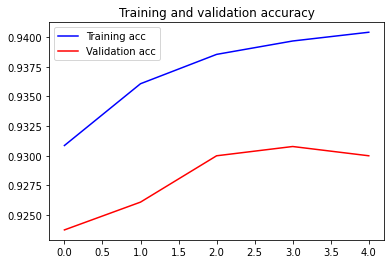

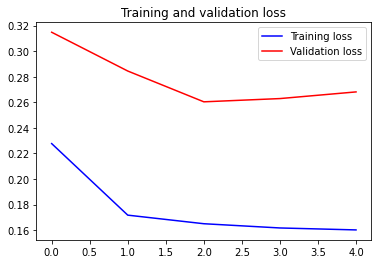

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()